# Notebook II : L'intrication quantique et les états de Bell

## Exercice 1 : Créer et dessiner un circuit d'état de Bell singlet

Les circuits de Bell sont des circuits spécifiques qui génèrent des états de Bell, ou paires EPR, une forme de vecteurs de base intriqués et normalisés. En d'autres termes, ce sont les circuits que nous utilisons pour générer des états intriqués, un ingrédient clé des calculs quantiques.

Il existe 4 états de Bell différents.

Votre tâche : construisez un circuit qui génère l'état de Bell.

In [1]:
### Install Qiskit, if needed

#%pip install qiskit[visualization]==1.0.2
#%pip install qiskit_aer
#%pip install qiskit_ibm_runtime
#%pip install matplotlib
#%pip install pylatexenc
#%pip install qiskit-transpiler-service

In [2]:
# imports

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info import Statevector, Operator, SparsePauliOp
from qiskit.primitives import StatevectorSampler, PrimitiveJob
from qiskit.circuit.library import TwoLocal, UGate
from qiskit.circuit import Parameter

from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram, array_to_latex
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
from qiskit_ibm_runtime import QiskitRuntimeService # Qiskit Runtime imports
from qiskit_ibm_runtime import QiskitRuntimeService, Session, EstimatorV2 as Estimator
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeSydneyV2

import numpy as np
from typing import List, Callable
from scipy.optimize import minimize
from scipy.optimize._optimize import OptimizeResult
# Plotting routines
import matplotlib.pyplot as plt
import matplotlib.ticker as tck


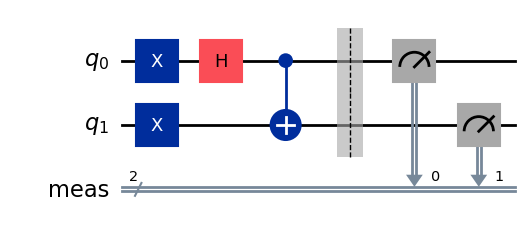

In [3]:
# Construire un circuit pour former un état de Bell psi-moins
# Appliquer des portes au circuit quantique fourni, qc

cq = QuantumCircuit(2)

# Appliquer la porte X de Pauli aux qubits 0 et 1



# Ajouter une porte Hadamade au qubit 0


# Effectuer une porte CNOT sur le qubit 1, contrôlée par le qubit 0


### Mesurer et visuliser le résultat ###
cq.measure_all()
cq.draw('mpl')

## Exercice 2 : Téléportation quantique

L'information quantique ne peut pas être copiée en raison du « théorème de non-clonage », mais elle peut être “téléportée” dans le sens où un qubit peut être enchevêtré avec une ressource quantique et, par le biais d'un protocole de mesures et d'une communication « classique » de leurs résultats, l'état quantique d'origine peut être reconstruit sur un autre qubit. Ce processus détruit l'information contenue dans le qubit d'origine par le biais de la mesure.

Dans cet exercice, nous allons construire un état particulier du qubit et transférer cet état à un autre qubit en utilisant le protocole de téléportation. Nous examinerons ici des registres classiques et quantiques spécifiques, que nous devons donc importer.

### Créer le circuit de téléportation quantique

Définir un angle $\theta$ pour faire tourner notre qubit. Cela nous permettra de faire facilement des comparaisons entre l'état d'origine et l'état téléporté.

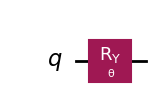

In [4]:
theta = Parameter('θ')

qr = QuantumRegister(1, 'q')
qc = QuantumCircuit(qr)
qc.ry(theta, 0)
qc.draw('mpl')

Alice possède l'information quantique $|\psi\rangle$ dans l'état $q$ et souhaite la transférer à Bob. La ressource qu'ils partagent est un état intriqué spécial appelé état de Bell
$$
|\Phi^+\rangle = \frac{1}{2} \left( |00\rangle + |11\rangle \right)
$$
avec le premier de la paire allant à Alice et le second à Bob. Alice dispose donc d'un registre à 2 qubits ($q$ et $Bell_0$) et Bob d'un registre à un qubit ($Bell_1$). Nous allons construire le circuit en copiant le `qc` original et en ajoutant les registres appropriés.

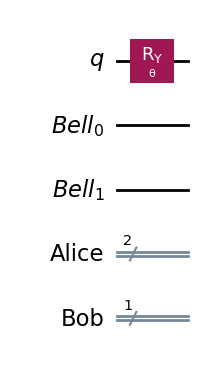

In [5]:
tele_qc = qc.copy()
bell = QuantumRegister(2, 'Bell')
alice = ClassicalRegister(2, 'Alice')
bob = ClassicalRegister(1, 'Bob')
tele_qc.add_register(bell, alice, bob)
tele_qc.draw('mpl')

Créez maintenant la paire de Bell avec $Bell_0$ allant à Alice et $Bell_1$ allant à Bob. Pour ce faire, on utilise une porte de Hadamard pour placer $Bell_0$ dans l'état $|+\rangle$, puis on effectue un CNOT avec le même qubit que celui de contrôle. Après avoir reçu leur qubit respectif, ils se séparent.

In [1]:
# Créer l'état de Bell avec les deux autre qubits



Ensuite, Alice effectue un CNOT contrôlé par $q$ sur $Bell_0$, qui lui transmet des informations sur l'état. Elle applique ensuite une porte de Hadamard sur $q$.

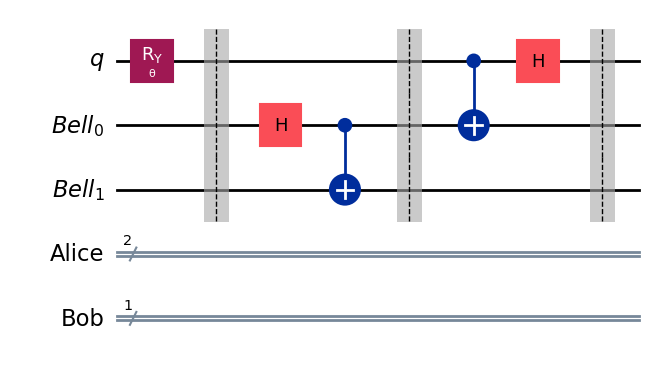

In [7]:
# Alice opère sur son qubits
tele_qc.cx(0, 1)
tele_qc.h(0)
tele_qc.barrier()
tele_qc.draw('mpl')

Alice mesure maintenant ses qubits et enregistre les résultats dans son registre.

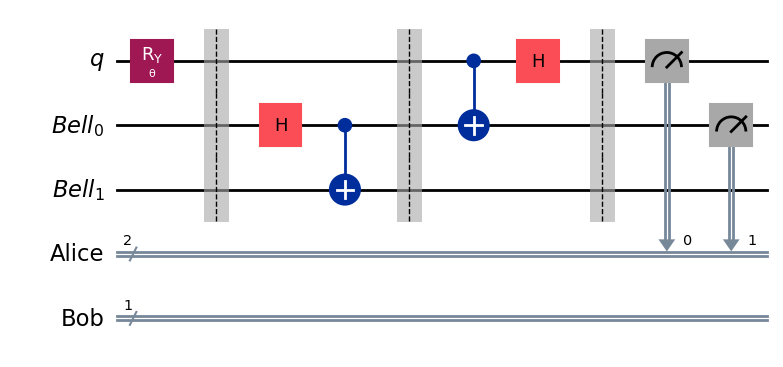

In [8]:
tele_qc.measure([qr[0], bell[0]], alice)
tele_qc.draw('mpl')

Le qubit de Bob possède maintenant l'information $|\psi\rangle$ du qubit d'Alice $q$ encodée dans $Bell_1$, mais il ne sait pas dans quelle base mesurer pour l'extraire. En conséquence, Alice doit partager l'information contenue dans son registre par un canal de communication *classique* (c'est pourquoi la téléportation ne viole pas la relativité restreinte, quelle que soit la distance qui sépare Alice et Bob). Elle demande à Bob d'effectuer une porte X sur son qubit si sa mesure de $Bell_0$ donne un résultat de 1, suivie d'une porte Z si sa mesure de $q$ donne un résultat de 1.

Les applications de ces portes peuvent être conditionnées par les résultats des mesures de deux façons :
- l'instruction `.c_if()` (https://qiskit.org/documentation/stubs/qiskit.circuit.Instruction.c_if.html), qui applique la porte qu'elle modifie si la valeur de l'index `ClassicalRegister` est égale à la valeur spécifiée. Notez que cela fonctionne **uniquement** sur les simulateurs.
- le `.if_test()` [context](https://qiskit.org/documentation/stubs/qiskit.circuit.QuantumCircuit.if_test.html) qui fonctionne de manière similaire, mais généralise la syntaxe pour permettre des conditionnelles imbriquées. Cela fonctionne à la fois sur les simulateurs et sur le matériel réel.

Ajouter les portes conditionnelles appropriées pour transformer le qubit de Bob dans la base -.

In [2]:
graded_qc = tele_qc.copy()

##############################
# Ajoute des portes quantiques aux graded_qc ici



##############################

graded_qc.draw('mpl')

NameError: name 'tele_qc' is not defined

Enfin, Bob peut mesurer son qubit, ce qui donnerait des résultats avec les mêmes probabilités que si Alice l'avait mesuré à l'origine.

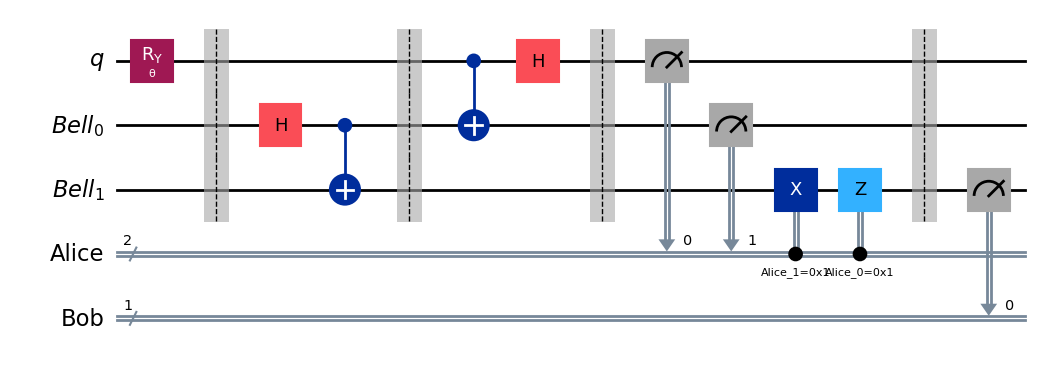

In [10]:
graded_qc.barrier()
graded_qc.measure(bell[1], bob)
graded_qc.draw('mpl')

In [11]:
from qiskit_aer.primitives import Sampler

angle = 5*np.pi/7

sampler = Sampler()
qc.measure_all()
job_static = sampler.run(qc.assign_parameters({theta: angle}))
job_dynamic = sampler.run(graded_qc.assign_parameters({theta: angle}))

print(f"Original Dists: {job_static.result().quasi_dists[0].binary_probabilities()}")
print(f"Teleported Dists: {job_dynamic.result().quasi_dists[0].binary_probabilities()}")

Original Dists: {'0': 0.193359375, '1': 0.806640625}
Teleported Dists: {'011': 0.044921875, '111': 0.2177734375, '000': 0.0419921875, '010': 0.0439453125, '001': 0.046875, '100': 0.2294921875, '110': 0.1962890625, '101': 0.1787109375}


Attendez, les résultats sont différents ! Alors que la mesure du $q$ original d'Alice donne le ratio attendu de résultats, les distributions téléportées ont beaucoup plus de valeurs. En effet, le circuit téléporté inclut les mesures de $q$ et $Bell_0$ d'Alice, alors que nous souhaitons uniquement que les mesures de $Bell_1$ de Bob produisent la même distribution.

Afin de rectifier cela, nous devons prendre les comptes *marginaux*, ce qui signifie que nous combinons les résultats dans lesquels Bob mesure un 0 et tous les résultats dans lesquels Bob mesure un 1 sur toutes les combinaisons possibles. Cela se fait avec la [méthode] `marginal_counts` (https://qiskit.org/documentation/stubs/qiskit.result.marginal_counts.html) de `qiskit.result`, qui combine les résultats sur les indices de mesure.

### Marginaliser les comptes téléportés

In [12]:
from qiskit.result import marginal_counts

# marginalize counts
result = job_dynamic.result().quasi_dists[0].binary_probabilities()
#tele_counts = [marginal_counts(result, [qubit]) for qubit in range(3)]
tele_counts = marginal_counts(result, indices=[2])

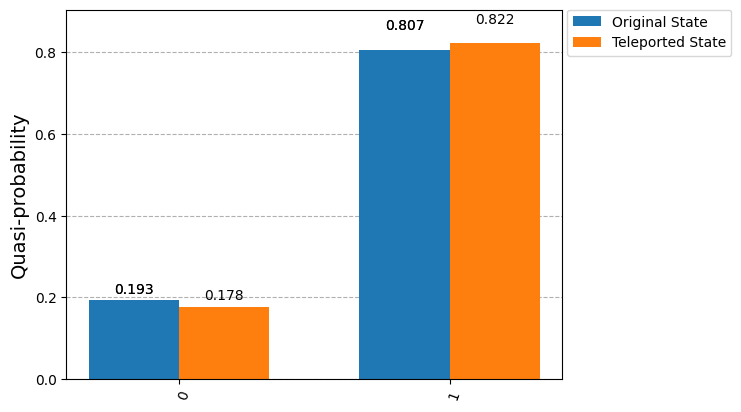

In [13]:
legend = ['Original State', 'Teleported State']
plot_histogram([job_static.result().quasi_dists[0].binary_probabilities(), tele_counts], legend=legend)

### Féliciations ! Vous avez réussi à compléter une mission de téléportation quantique ! 